<a href="https://colab.research.google.com/github/juanpi19/medium-articles/blob/main/interrupted-time-series-02/interrupted_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Parameters for simulation
days = 365
campaign_start = 183  # Day the campaign starts
baseline_sales = 50  # Average daily sales before the campaign
trend = 0.1  # Daily increase in baseline sales
weekly_seasonality = [0, 0, 0, 0, 10, 20, 30]  # Higher sales on weekends
noise_sd = 5  # Standard deviation of random noise

# Campaign impact parameters
campaign_lift = 20  # Immediate sales increase due to campaign
post_campaign_trend_increase = 0.05  # Additional daily increase in trend after campaign

# Simulate data
days_array = np.arange(days)
sales = (
    baseline_sales
    + trend * days_array
    + np.tile(weekly_seasonality, len(days_array) // 7 + 1)[:days]
    + np.random.normal(0, noise_sd, size=days)
)

# Add campaign effect
sales[campaign_start:] += campaign_lift  # Immediate lift
sales[campaign_start:] += post_campaign_trend_increase * np.arange(days - campaign_start)

# Create DataFrame
data = pd.DataFrame({
    "Day": days_array + 1,
    "Sales": sales,
    "Campaign": [0 if day < campaign_start else 1 for day in days_array],
})

# Convert Day column to a datetime format
start_date = "2024-01-01"
data["Date"] = pd.date_range(start=start_date, periods=days)

# Drop the old 'Day' column
data = data[["Date", "Sales", "Campaign"]]

In [18]:
data.head()

,Date,Sales,Campaign,time,time_since_campaign_launch
0,2024-01-01,52.483571,0,0,0
1,2024-01-02,49.408678,0,1,0
2,2024-01-03,53.438443,0,2,0
3,2024-01-04,57.915149,0,3,0
4,2024-01-05,59.229233,0,4,0


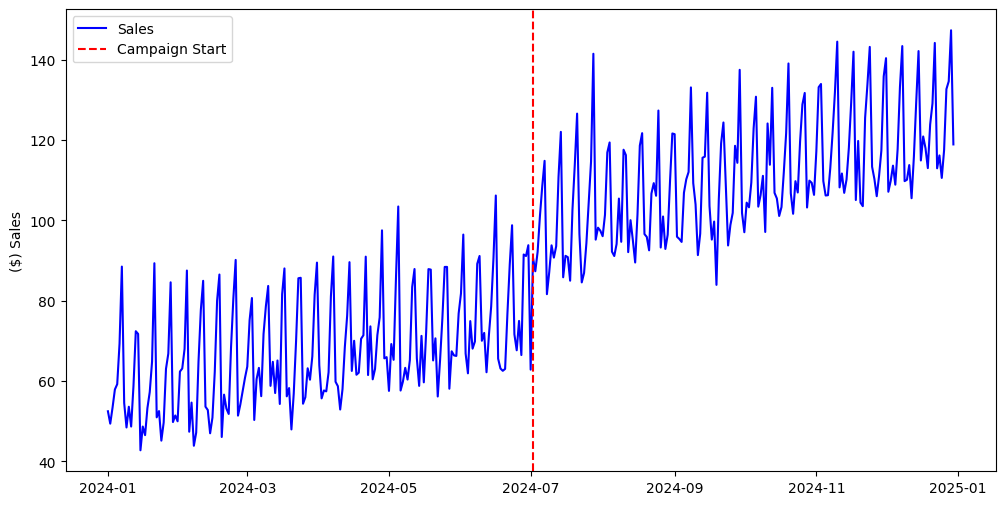

In [4]:
# Plot the data again with the Date column
plt.figure(figsize=(12, 6))
plt.plot(data["Date"], data["Sales"], label="Sales", color="blue")
plt.axvline(data.loc[campaign_start, "Date"], color="red", linestyle="--", label="Campaign Start")
plt.ylabel("($) Sales")
plt.legend()
plt.show()


In [6]:
data

,Date,Sales,Campaign
0,2024-01-01,52.483571,0
1,2024-01-02,49.408678,0
2,2024-01-03,53.438443,0
3,2024-01-04,57.915149,0
4,2024-01-05,59.229233,0
...,...,...,...
360,2024-12-26,117.446733,1
361,2024-12-27,132.663695,1
362,2024-12-28,134.606199,1
363,2024-12-29,147.308559,1


## Regression

In [13]:
campaign_launch = '2024-07-02'
data['time'] = range(len(data))
data['time_since_campaign_launch'] = 0
data.loc[data['Campaign'] == 1, 'time_since_campaign_launch'] = range(sum(data['Campaign'] == 1))

In [16]:
data.set_index("Date").loc['2024-07-01':].head(5)

,Sales,Campaign,time,time_since_campaign_launch
Date,,,,
2024-07-01,62.845538,0,182,0
2024-07-02,90.712362,1,183,0
2024-07-03,87.332686,1,184,1
2024-07-04,92.170002,1,185,2
2024-07-05,101.116188,1,186,3


In [17]:
formula = 'Sales ~ time + Campaign + time_since_campaign_launch'
ols_model = smf.ols(formula=formula, data=data).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     410.1
Date:                Tue, 26 Nov 2024   Prob (F-statistic):          6.89e-116
Time:                        18:25:44   Log-Likelihood:                -1434.8
No. Observations:                 365   AIC:                             2878.
Df Residuals:                     361   BIC:                             2893.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

- **Baseline Sales:** 56.98. This is the expected sales in dollars at time zero, before accounting for any changes over time or the marketing campaign launch.

- **Impact of Campaign Launch:** 18.65. The launch of the campaign had an immediate positive effect of $18.65, indicating a positive impact of the campaign on sales

- **Time:** 0.11. This coefficient captures the trend. Indicating that independently of the marketing campaign, sales were increasing over time.

- **Time Since Campaign Launch:** 0.03. This coefficient captures how much the trend has changed after the intervention, or the long term effect. This indicates a positive change in the trend over time after the campaign launch. Although the p-value (0.117) indicates that the result is not statistically significant.